# IMDB Movie Review Classification

# Structure:
# 1. Attention is all we need.
# 2. Why eliminate overfitting is so important?
# 3. Summarise signs of overfitting.
# 4. Imoprt required libary and module
# 5. Review content
# 6. Beat the baseline: 50% accuracy!
# 6-1. Preparing the data
# 6-2. Sanity Check
# 7. Models for IMDB movie revview classification
<br>7-1. Processing words as a sequence: Transformer encoder based model
<br>7-2. Implementing positional embedding to Transformer encoder based model
<br>7-3. Bidirectional LSTM
<br>7-4. GloVe
<br>7-5. Bag-of-words: N-gram(N=2)
<br>7-6. Bigram
<br>7-7. TF-IDF bigram model
# 8. Created a new model for inference (inference_model)
# 9. Attention is all we need?
# 10. References

# 1. Attention is all we need.
#### In this coursework 2, we applied seven different methods on the IMDB sentiment classification mission. Since the publication of 'Attention is all you need', it has been sensational in the deep learning field, so the most we dive into is transformer architecture.

# 2. Why eliminate overfitting is so important?
#### It turns the biggest challenge for DLWP warriors is not the freezing winter morning, it is overfitting instead. Since we have been fought against overfitting during our entire term, it is nessassary to summarise some important concept of overfitting in this coursework 1 and 2.

#### Alleviate Overfitting is an important concept and step in deep learning, including the following reason:
&nbsp;&nbsp;&nbsp;&nbsp;1. Improve model generalisation. Overfitting situation represents the model only performs well on the training data instead of unseen data, meaning by alleviating overfitting, the model can have a better prediction ability in the real world application, and it is usually our final purpose as well.

&nbsp;&nbsp;&nbsp;&nbsp;2. Elevating model interpretability. Unfortunately, the real world data is full of noises. An overfitting model could learn noises in dataset instead of the useful patterns. Hence, alleviate overfitting is not only a nessasary process to reducing wasting of resources, but also training a useful model.

# 3. Summarise signs of overfitting.
### By observing the relative value among training loss and validation loss, and training accuracy and validation accuracy in coursework 1 and coursework 2, we can summarise the sign of overfitting:

#### 1. Training loss and validation loss.
If the training loss keep decreasing, but the validation loss starts to increase or stop decreasing, it is an typical overfitting, which means the model performs well on training dataset but performs poorly on unseen(validation) dataset.

#### 2. Training accuracy and validation accuracy.
If training accuracy keeps increasing, but validation accuracy stop increasing or starts decreasing, it is also a sign of overfitting because the model possibily just remeber the pattern of the training dataset rather than learning the ability to generalise to new data.

##### 3. The instability of model performance is a sign of overfitting as well. If the model performs very volatile on validation dataset, it usually represents the model is too sensitive to the training dataset, rather than generalise effetively.

##### 4. Unusual decrease in performance of validation datasest after increased in performance at the begin is also an indication of overfitting because the convergence speed is too fast so the model haven't learned enough features to become more generalision.

# 4. Imoprt required libary and module

In [ ]:
# codes from Jérémie's ARTIFICIAL INTELLIGENCE (2023-24), Goldsmiths
# codes from Ch.11, DLWP
# codes from ChatGPT 4, 23/12~31/12, 2023

import os, pathlib, shutil, random
import pandas as pd
import numpy as np
import keras
import sys
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from scipy.stats import norm
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
# codes from Jérémie's ARTIFICIAL INTELLIGENCE (2023-24), Goldsmiths

if 'google.colab' in sys.modules:
    from google.colab import drive
    drive.mount('/content/drive')
    os.chdir('/content/drive/My Drive/Colab Notebooks')      # 'My Drive' is the default name of Google Drives
    os.listdir()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### Downloading the data and delete train/unsup category. Because these catgories
##### 7 minuites faster than process by T4 GPU.

#### Downloading the data and delete train/unsup category. Because these categories has no obvious negative of positive labels so they will not be used in our mission. The processing speed could increase by decreaing the data amount.

In [ ]:
# codes from Jérémie's ARTIFICIAL INTELLIGENCE (2023-24), Goldsmiths

!curl -O https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar -xf aclImdb_v1.tar.gz
!rm -r aclImdb/train/unsup

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 80.2M  100 80.2M    0     0  5622k      0  0:00:14  0:00:14 --:--:-- 8402k


In [ ]:
# codes from Ch.11, DLWP

!ls aclImdb

imdbEr.txt  imdb.vocab	README	test  train


# 5. Review content
#### According to ***DLWP 11.3.1***, we should "...always inspect what our data looks like before we dive into modeling it. It will ground our intuition about what our model is actually doing.":

In [ ]:
# codes from Ch.11, DLWP

!cat aclImdb/train/pos/4077_10.txt

I first saw this back in the early 90s on UK TV, i did like it then but i missed the chance to tape it, many years passed but the film always stuck with me and i lost hope of seeing it TV again, the main thing that stuck with me was the end, the hole castle part really touched me, its easy to watch, has a great story, great music, the list goes on and on, its OK me saying how good it is but everyone will take there own best bits away with them once they have seen it, yes the animation is top notch and beautiful to watch, it does show its age in a very few parts but that has now become part of it beauty, i am so glad it has came out on DVD as it is one of my top 10 films of all time. Buy it or rent it just see it, best viewing is at night alone with drink and food in reach so you don't have to stop the film.<br /><br />Enjoy

##### Let's have a more specific review:

In [ ]:
# codes from Jérémie's ARTIFICIAL INTELLIGENCE (2023-24), Goldsmiths
# codes from Ch.11, DLWP
# codes from ChatGPT 4, 23/12~31/12, 2023

def load_imdb_dataset(base_path):
    labels = {'pos': 1, 'neg': 0}
    rows = []                                                 # use list to storage all rows

    for label_type in ('neg', 'pos'):
        dir_name = os.path.join(base_path, label_type)
        files = os.listdir(dir_name)
        print(f"Loading {len(files)} {label_type} reviews")

        for fname in files:
            if fname.endswith('.txt'):
                with open(os.path.join(dir_name, fname), encoding='utf-8') as f:
                    text = f.read()
                rows.append([text, labels[label_type]])       # Add each row of data to the list

    df = pd.DataFrame(rows, columns=['review', 'sentiment'])  # create a dataFrame directly from a list
    return df

base_path = 'aclImdb/train'
df = load_imdb_dataset(base_path)
print(df['sentiment'].value_counts())

print(df.sample(5))                                           # random sampling of five elements

Loading 12500 neg reviews
Loading 12500 pos reviews
0    12500
1    12500
Name: sentiment, dtype: int64
                                                  review  sentiment
10166  Way back in 1967, a certain director had no id...          0
2470   There are a number of problems with this movie...          0
6952   This film is pure 'Hollywood hokum'. It is bas...          0
14433  I've never been huge on IMAX films. They're co...          1
9287   I recently decided to revisit The Omen trilogy...          0


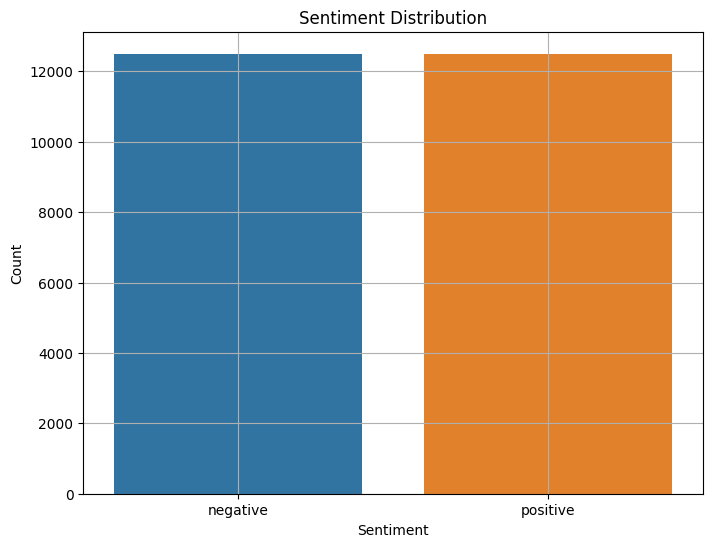

In [ ]:
# codes from ChatGPT 4, 23/12~31/12, 2023

# convert numeric labels to text labels
df['sentiment_label'] = df['sentiment'].map({1: 'positive', 0: 'negative'})

# draw count bar chart using seaborn
plt.figure(figsize=(8, 6))                # set image size
sns.countplot(x=df['sentiment_label'])
plt.title('Sentiment Distribution')       # set title
plt.xlabel('Sentiment')                   # set x-axis labels
plt.ylabel('Count')                       # set y-axis labels
plt.grid(True)                            # show grid lines
plt.show()                                # display the chart

# 6. Beat the baseline: 50% accuracy.
#### Since we've been remind that we have to clarify why the baseline of sentiment classification for IMDB movie reviews is 50% in coursework 1, here we are going to explain that. Because the sentiment classification mission we are goint to do here is either positive or negative, which means the accuracy rate is 50/50 by random guessing. Therefore, the baseline we set is more than 50% accuracy or the model is useless( at least need to be better than arandom guess, right?). Of course, if this is a regression mission, the baseline could be average, median, MSE, RMSE, or MAE, etc.

## 6-1. Preparing the data

In [ ]:
# codes from Jérémie's ARTIFICIAL INTELLIGENCE (2023-24), Goldsmiths
# codes from Ch.11, DLWP

batch_size = 32                                  # DLWP 11.3.1
base_dir = pathlib.Path("aclImdb")
train_dir = base_dir / "train"
val_dir = base_dir / "val"
test_dir = base_dir / "test"

for category in ("neg", "pos"):
    if not os.path.isdir(val_dir / category):    # do this only once
        os.makedirs(val_dir / category)          # make 'neg'/'pos' dir in validation
        files = os.listdir(train_dir / category) # list files in 'train'
        random.Random(1337).shuffle(files)       # shuffle using a seed
        num_val_samples = int(0.2 * len(files))  # 2% of our samples for validation
        val_files = files[-num_val_samples:]
        for fname in val_files:                  # move our files
            shutil.move(
                train_dir / category / fname,
                val_dir / category / fname
            )

In [ ]:
# codes from Jérémie's ARTIFICIAL INTELLIGENCE (2023-24), Goldsmiths
# codes from Ch11., DLWP

train_ds = tf.keras.utils.text_dataset_from_directory(
    train_dir, batch_size=batch_size
)
val_ds = tf.keras.utils.text_dataset_from_directory(
    val_dir, batch_size=batch_size
)
test_ds = tf.keras.utils.text_dataset_from_directory(
    test_dir, batch_size=batch_size
)
text_only_train_ds = train_ds.map(lambda x, y: x) # creates a new dataset (text_only_train_ds) that contains only the text portion of the training dataset, with labels removed.

Found 20000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.
Found 25000 files belonging to 2 classes.


## 6-2. Sanity Check

#### To ensure the format of dataset meets the requirements for model training, ***DLWP Listing 11.2*** displays the shapes and dtypes of the first batch:
#### Batch size: The `inputs.shape` is with 32 one dimensional samples that equals to `targets.shape`.
#### Data type: It is correct that inputs data type is `string` and outputs data type is `int32`(category label).
#### [0] Check the input and output for the first sample.

#### According to ***DLWP listing 8.9*** and Chapter ***11.3.1***, we cab apply the same method to create Dataset objects:

In [ ]:
# codes from ChatGPT 4, 23/12~31/12, 2023

for inputs, targets in train_ds:
  print("inputs.shape:", inputs.shape)
  print("inputs.dtype:", inputs.dtype)
  print("targets.shape:", targets.shape)
  print("targets.dtype:", targets.dtype)
  print("inputs[0]:", inputs[0])
  print("targets[0]:", targets[0])
  break

inputs.shape: (32,)
inputs.dtype: <dtype: 'string'>
targets.shape: (32,)
targets.dtype: <dtype: 'int32'>
inputs[0]: tf.Tensor(b"I have seen this film three times now, and each time I see it, it becomes more personal and more emotional to watch.<br /><br />The acting is amazing, which is not hard to believe since it is Daniel Day Lewis, who is an amazing actor. Brenda Fricker is the surprise wonder in it, though. She captures your heart as the mother of a physically disabled boy, who is not able to walk, or speak until he is in his late teens.<br /><br />I can't say enough good things about the movie, but I will stop here. I recommend it to anyone who enjoys movies that are based on actual events, or just enjoy good dramas in general.", shape=(), dtype=string)
targets[0]: tf.Tensor(1, shape=(), dtype=int32)


#### Since we need to control input size, we can calculate the average word count and the ratio of that over 600 words.

Average word count: 233.7872
Percentage of reviews with word count between 0 and 100: 11.70%
Percentage of reviews with word count between 100 and 200: 46.62%
Percentage of reviews with word count between 200 and 300: 18.66%
Percentage of reviews with word count between 300 and 400: 9.54%
Percentage of reviews with word count between 400 and 500: 5.36%
Percentage of reviews with word count between 500 and 600: 3.14%
Percentage of reviews with word count between 600 and 700: 1.86%
Percentage of reviews with word count between 700 and 800: 1.23%
Percentage of reviews with word count between 800 and 900: 0.80%
Percentage of reviews with word count between 900 and 1000: 0.85%
Percentage of reviews with word count between 1000 and 1100: 0.16%
Percentage of reviews with word count between 1100 and 1200: 0.02%
Percentage of reviews with word count between 1200 and 1300: 0.01%
Percentage of reviews with word count between 1300 and 1400: 0.02%
Percentage of reviews with word count between 1400 

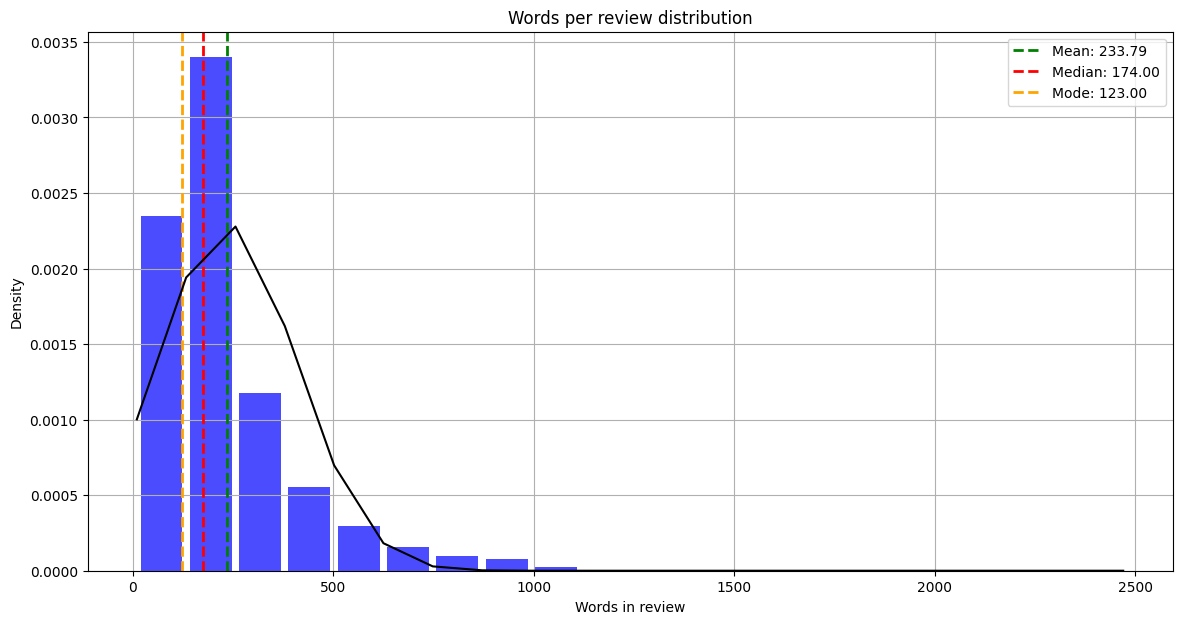

In [ ]:
# idea from "https://www.kaggle.com/code/derrelldsouza/imdb-sentiment-analysis-eda-ml-lstm-bert?kernelSessionId=68871348"
# codes from ChatGPT 4, 23/12~31/12, 2023

# count the number of words in each comment
df['word_count'] = df['review'].apply(lambda x: len(x.split()))

# calculate the average number of words
average_word_count = df['word_count'].mean()
print(f"Average word count: {average_word_count}")

# calculate the percentage of comments in an interval of 100 words
word_count_bins = list(range(0, max(df['word_count']), 100)) + [max(df['word_count'])]
word_count_hist = np.histogram(df['word_count'], bins=word_count_bins)
bin_edges = word_count_hist[1]
bin_counts = word_count_hist[0]

# print the percentage of comments for each range
for i in range(len(bin_edges)-1):
    bin_percentage = (bin_counts[i] / df.shape[0]) * 100
    print(f"Percentage of reviews with word count between {bin_edges[i]} and {bin_edges[i+1]}: {bin_percentage:.2f}%")

# calculate the proportion of reviews longer than 600 words
over_600_words = df[df['word_count'] > 600].shape[0]
percentage_over_600 = (over_600_words / df.shape[0]) * 100
print(f"Percentage of reviews over 600 words: {percentage_over_600:.2f}%")

# plot words distribution histogram with mean, median and mode
plt.figure(figsize=(14, 7))
n, bins, patches = plt.hist(df['word_count'], bins=20, color='blue', alpha=0.7, rwidth=0.85, density=True)

# add mean, median and mode lines
plt.axvline(average_word_count, color='g', linestyle='dashed', linewidth=2, label=f'Mean: {average_word_count:.2f}')
median_val = np.median(df['word_count'])
mode_val = df['word_count'].mode().values[0]
plt.axvline(median_val, color='r', linestyle='dashed', linewidth=2, label=f'Median: {median_val:.2f}')
plt.axvline(mode_val, color='orange', linestyle='dashed', linewidth=2, label=f'Mode: {mode_val:.2f}')
plt.legend()

# calculate and plot the fitted probability density function
density = norm.pdf(bins, average_word_count, np.std(df['word_count']))
plt.plot(bins, density, color='black')

# set title and axis labels
plt.title('Words per review distribution')
plt.xlabel('Words in review')
plt.ylabel('Density')

# plot grid and chart
plt.grid(True)
plt.show()


## Everything is ready. Let's get started to train our models!

# 7. Models for IMDB movie revview classification

## Processing words as a sequence: The sequence model approach (DLWP 11.3.3)

#### Vectorizing the data
##### ***Listing 11.12***: "In order to keep a manageable input size*, we’ll truncate the inputs after the first 600 words. This is a reasonable choice, since the average review length is 233 words, and only 5% of reviews are longer than 600 words."

In [ ]:
# codes from Jérémie's ARTIFICIAL INTELLIGENCE (2023-24), Goldsmiths
# codes from Ch.11, DLWP

max_length = 600                        # words in reviews; if the words amount of a review is lower than 600, padding to 600 with 0
max_tokens = 20000                      # align with "vocab_size = 20000" in the embeding layer of Transformer encoder
text_vectorization = tf.keras.layers.TextVectorization(
    max_tokens=max_tokens,
    output_mode="int",
    output_sequence_length=max_length,  # manage input size here.*
)
text_vectorization.adapt(text_only_train_ds)

# DLWP 11.2-4, ensure operation runs in the tf.data workflow to get higher efficiency if we train models on GPU or TPU.
int_train_ds = train_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
int_val_ds = val_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
int_test_ds = test_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)

#### View vocabulary
#### According to ***DLWP 11.2.3***, some vacabulary may not exsit in our list, that's because it is extremly rare or it is not in the training data, hence we use an index to the use an “out of vocabulary” index (abbreviated as OOV index)—a catch-all for any token that wasn’t in the index.OOV token usually takes place as (index 1), and the mask token as (index 0), so we can find the first 2 vocabulary is '' and [UNK].

In [ ]:
# idea from "https://www.kaggle.com/code/lakshmi25npathi/sentiment-analysis-of-imdb-movie-reviews?kernelSessionId=40627787"

vocabulary = text_vectorization.get_vocabulary()
print(vocabulary[:100])

['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i', 'this', 'that', 'br', 'was', 'as', 'for', 'with', 'but', 'movie', 'film', 'on', 'not', 'are', 'you', 'his', 'have', 'he', 'be', 'one', 'its', 'at', 'all', 'by', 'an', 'they', 'who', 'from', 'so', 'like', 'her', 'or', 'just', 'about', 'has', 'if', 'out', 'some', 'there', 'what', 'good', 'more', 'when', 'very', 'even', 'my', 'no', 'she', 'up', 'would', 'which', 'only', 'time', 'really', 'story', 'their', 'were', 'see', 'had', 'can', 'me', 'than', 'we', 'much', 'well', 'get', 'been', 'also', 'into', 'will', 'other', 'because', 'people', 'bad', 'first', 'do', 'great', 'how', 'most', 'dont', 'him', 'made', 'then', 'movies', 'films', 'any', 'make', 'could', 'them', 'way']


---

## 7-1. The Transformer architecture

#### The Transformer encoder implemented as a subclassed `Layer`

##### The dimension of the embedding vector is `embed_dim` and there are `num_heads` heads. For each head, each input vector will be divided into small segments of length `embed_dim` / `num_heads`. E.g. 256 / 4 = 64(works), 250 / 4 = 62.5(doesn't work).

##### DLWP 9.3.3, 11.4.3 Prevents the vanishing gradient problem and maintains feature stability in the deep layers of the network, thereby promoting efficient training of deeper Transformer models. In this way, layer normalization helps the model learn long-distance dependencies better

##### Padding Mask: This type of mask is used to mask (ie ignore) padding tokens in the input sequence. In text processing, it is common to use special padding tokens such as [PAD] to ensure that all sequences are of the same length. When computing attention, we do not want the model to process these filler tokens as valid inputs because they do not carry any meaningful information. The fill mask is used to set the attention weights at these locations to 0, ensuring that the model's attention is only focused on non-fill tokens.

##### Look-Ahead Mask (or Decoder Mask): This type of mask is used in the decoder part to prevent the model from "peeping" at future tokens when generating output. In sequence generation tasks (such as text generation), the model needs to generate output step by step and should only rely on previous tokens. The lookahead mask ensures that the model does not have access to information about subsequent tokens when calculating attention for the current token.

##### Expand the mask in the appropriate dimensions (using tf.newaxis) and apply it to the multi-head attention layer.

##### Since different comments may be of different lengths when dealing with text data, special padding symbols such as "[PAD]" are often used to ensure that all input sequences are of the same length. In this case, using a fill mask can help the model ignore the positions occupied by these fill symbols, ensuring that the model's attention mechanism only focuses on meaningful content.

##### In a task like IMDB sentiment classification, our model needs to look at and consider all words in the input sequence (except filler symbols) to understand the overall sentimental disposition. Therefore, there is no need to prevent the model from "seeing" any specific part of the sequence, which is what lookahead masking does in sequence generation tasks.

In [ ]:
# codes from Jérémie's ARTIFICIAL INTELLIGENCE (2023-24), Goldsmiths
# codes from Ch.11, DLWP

class TransformerEncoder(tf.keras.layers.Layer):                 # DLWP Listing 11.21
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):  # **kwargs: keyword arguments
        super().__init__(**kwargs)
        self.embed_dim = embed_dim                               # Parameters!
        self.dense_dim = dense_dim                               # ! embed_dim % num_head must be zero! (divisibility)
        self.num_heads = num_heads
        self.attention = tf.keras.layers.MultiHeadAttention(     # Multi-head-attention, DLWP 11.4.2; able to process query, key, and value
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = tf.keras.Sequential(                   # dense layer on top: like a nonlinearity; "top" means above the order in the model's architectural hierarchy. In other words, these dense layers are performed after the multi-head attention layer and are therefore called "on top".
            [tf.keras.layers.Dense(dense_dim, activation="relu"),# Introduce ReLU to ease the level of vanishing gradient,
             tf.keras.layers.Dense(embed_dim),]                  # for ReLU(x)=max(0,x): if x>0, outputs=1; if x<=0, outputs=0
        )
        self.layernorm_1 = tf.keras.layers.LayerNormalization()  # layer norm; DLWP 9.3.3, 11.4.3
        self.layernorm_2 = tf.keras.layers.LayerNormalization()  # default apllied on the last dim (not the whole layer)

    def call(self, inputs, mask=None):                           # We use padding by "max_length = 600" in "Vectorize the data"
        if mask is not None:                                     # optional mask (used in the decoder, see
            mask = mask[:, tf.newaxis, :]                        # translation notebook for an analysis, Or, since the data has been padded, we therefore keep these codes)
        attention_output = self.attention(
            inputs, inputs, attention_mask=mask                  # We acutally use only two inputs: query for an input; value and key for an input
        )
        proj_input = self.layernorm_1(inputs + attention_output) # inputs + attn: residual connection, DLWP 9.3.2, to solve the problem of "vanishing gradient" by adding the input of a layer add back to its output
        proj_output = self.dense_proj(proj_input)                # Dense layer on top: like a nonlinearity; "top" means above the order in the model's architectural hierarchy.
        return self.layernorm_2(proj_input + proj_output)        #  In other words, these dense layers are performed after the multi-head attention layer and are therefore called "on top".

    def get_config(self):                                        # retrieve config as a dict
        config = super().get_config()                            # (required for Keras layers)
        config.update({                                          # If we excute x=TransformerEncoder(embed_dim=256, num_heads=2, dense_dim=32),
            "embed_dim": self.embed_dim,                         #  the returned dictionary includes (embed_dim=256, num_heads=2, dense_dim=32).
            "num_heads": self.num_heads,                         # For example: layer=PositionalEmbedding(sequence_length,input_dim,output_dim)
            "dense_dim": self.dense_dim,                         #  config=layer.get_config()
        })                                                       #  new_layer=PositionalEmbedding(sequence_length,input_dim,output_dim) (same configuration)
        return config


#### DLWP `Listing 11.25`Using the Transformer encoder for text classification

In [ ]:
# codes from Jérémie's ARTIFICIAL INTELLIGENCE (2023-24), Goldsmiths
# codes from Ch.11, DLWP

vocab_size = 20000 # Align with "max_size = 20000" in the Vectorizing the data because we need to ensure the text vectorization to embedding is same.
embed_dim = 256    # Divisibility by hum_heads
num_heads = 2
dense_dim = 32

inputs = tf.keras.Input(shape=(None,), dtype="int64")
x = tf.keras.layers.Embedding(vocab_size, embed_dim)(inputs) # 1. Regular embeddings
x = TransformerEncoder(embed_dim, dense_dim, num_heads)(x)   # 2. Transformer encoder, only 1 layer
x = tf.keras.layers.GlobalMaxPooling1D()(x)                  # (reduce full sequence to a single vector...)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)  # the output of sigmoid is between 0 to 1, making it is suitable for binary classification task
model = tf.keras.Model(inputs, outputs)
model.compile(
    optimizer="rmsprop",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding (Embedding)       (None, None, 256)         5120000   
                                                                 
 transformer_encoder (Trans  (None, None, 256)         543776    
 formerEncoder)                                                  
                                                                 
 global_max_pooling1d (Glob  (None, 256)               0         
 alMaxPooling1D)                                                 
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 257   

### Training and evaluating the Transformer encoder based model
#### T100 GPU is 20 minutes faster than process by T4 GPU.
#### According to our definition of overfitting, training loss is steady decrease but also steady increase invalidation loss. Moreover, training accuracy is steady increase in, but the validation accuracy is jumping back and forth and even decreaed in the last few epoch. We can conclude that it is overfitting.

In [ ]:
# codes from Jérémie's ARTIFICIAL INTELLIGENCE (2023-24), Goldsmiths

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        str(base_dir / "transformer_encoder.h5"),
        save_best_only=True

    )
]
history = model.fit(
    int_train_ds,
    validation_data=int_val_ds,
    epochs=20,
    callbacks=callbacks
)

Epoch 1/20
625/625 [==============================] - 40s 57ms/step - loss: 0.5081 - accuracy: 0.7596 - val_loss: 0.3499 - val_accuracy: 0.8450


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/20
625/625 [==============================] - 25s 40ms/step - loss: 0.3499 - accuracy: 0.8469 - val_loss: 0.3277 - val_accuracy: 0.8618
Epoch 3/20
625/625 [==============================] - 22s 34ms/step - loss: 0.3121 - accuracy: 0.8676 - val_loss: 0.3136 - val_accuracy: 0.8656
Epoch 4/20
625/625 [==============================] - 19s 30ms/step - loss: 0.2857 - accuracy: 0.8801 - val_loss: 0.3081 - val_accuracy: 0.8702
Epoch 5/20
625/625 [==============================] - 18s 28ms/step - loss: 0.2577 - accuracy: 0.8931 - val_loss: 0.3071 - val_accuracy: 0.8698
Epoch 6/20
625/625 [==============================] - 17s 27ms/step - loss: 0.2319 - accuracy: 0.9056 - val_loss: 0.3290 - val_accuracy: 0.8658
Epoch 7/20
625/625 [==============================] - 17s 27ms/step - loss: 0.2059 - accuracy: 0.9183 - val_loss: 0.3161 - val_accuracy: 0.8696
Epoch 8/20
625/625 [==============================] - 17s 27ms/step - loss: 0.1777 - accuracy: 0.9303 - val_loss: 0.3207 - val_accuracy:

In [ ]:
# codes from Jérémie's ARTIFICIAL INTELLIGENCE (2023-24), Goldsmiths

def plot_history(history):
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    acc = history.history["accuracy"]
    val_acc = history.history["val_accuracy"]
    epochs = range(1, len(loss) + 1)
    ax1.plot(epochs, loss, label="Training")
    ax1.plot(epochs, val_loss, label="Validation")
    ax1.set_title("Training and validation loss")
    ax1.legend()
    ax2.plot(epochs, acc, label="Training")
    ax2.plot(epochs, val_acc, label="Validation")
    ax2.set_title("Training and validation accuracy")
    ax2.legend()
    plt.show()

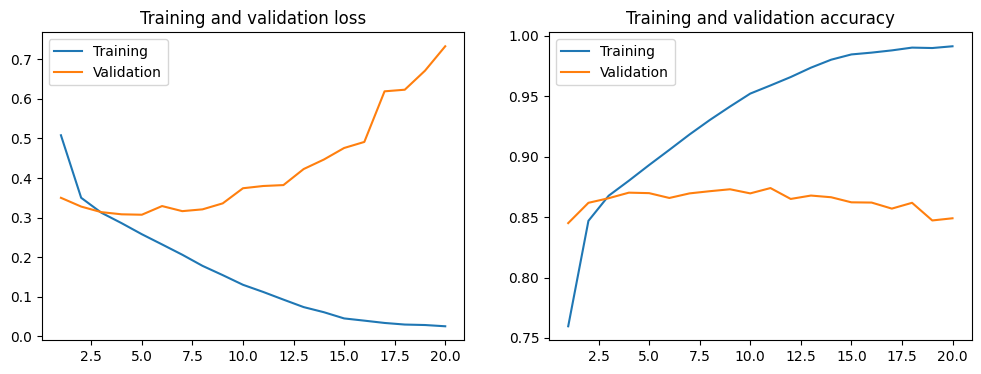

In [ ]:
plot_history(history) # a LOT of overfitting

#### We should run evaluate on out last model,but we want to see if it is affecting the test accuracy even if there's so many overfitting. The test accuracy is 0.871, which is not bad. But could we do better?

In [ ]:
# codes from Jérémie's ARTIFICIAL INTELLIGENCE (2023-24), Goldsmiths
# codes from Ch.11, DLWP

model = tf.keras.models.load_model(                             # DLWP 11.4.3
    str(base_dir / "transformer_encoder.h5"),
    custom_objects={"TransformerEncoder": TransformerEncoder}
)
print(f"Test acc: {model.evaluate(int_test_ds)[1]:.3f}")

782/782 [==============================] - 11s 14ms/step - loss: 0.3033 - accuracy: 0.8709
Test acc: 0.871


## 7-2. Implementing positional embedding as a subclassed layer
#### The previous transformer doesn't consider words sequence. Since Transformer is a hybrid approach, we can manually add sequence information by the positional encoding.

In [ ]:
# codes from Jérémie's ARTIFICIAL INTELLIGENCE (2023-24), Goldsmiths
# codes from Ch.11, DLWP

class PositionalEmbedding(tf.keras.layers.Layer): # Listing 11.24
    def __init__(self, sequence_length, input_dim, output_dim, **kwargs):   # Need to know the sequence length first
        super().__init__(**kwargs)
        self.token_embeddings = tf.keras.layers.Embedding(       # token embeddings: semantic information
            input_dim=input_dim, output_dim=output_dim           # (input_dim = vocab_dim, tokens are integers)
        )
        self.position_embeddings = tf.keras.layers.Embedding(    # position embeddings: syntactic/spatial information
            input_dim=sequence_length, output_dim=output_dim     # (input_dim = seq_len, instead of tokens, this
        )                                                        # learns one embedding per sequence *position*)
        self.sequence_length = sequence_length                   # store those params
        self.input_dim = input_dim
        self.output_dim = output_dim

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        embedded_tokens = self.token_embeddings(inputs)          # 1. create token embeddings
                                                                 # 2. create pos embeddings
        positions = tf.range(start=0, limit=length, delta=1)     #    (as many as our input length, delta: step size)
        embedded_positions = self.position_embeddings(positions)

        return embedded_tokens + embedded_positions              # 3. Both embeddings are simply combined together.

    def compute_mask(self, inputs, mask=None):                   # Turns int sequences into a mask (ignore all 0), example:
        return tf.math.not_equal(inputs, 0)                      # [ 12   3    54   3    0     0     ]
                                                                 # [ True True True True False False ]

    def get_config(self):                                        # retrieve config as a dict
        config = super().get_config()                            # (required for Keras layers)
        config.update({
            "output_dim": self.output_dim,
            "sequence_length": self.sequence_length,
            "input_dim": self.input_dim,
        })
        return config

### 7-2-1. Combining the Transformer encoder with positional embedding
#### The test accuracy is 0.884, which is better than the model without positional embedding.

In [ ]:
# codes from Jérémie's ARTIFICIAL INTELLIGENCE (2023-24), Goldsmiths
# codes from Ch.11, DLWP

vocab_size = 20000
sequence_length = 600
embed_dim = 256
num_heads = 2
dense_dim = 32

inputs = tf.keras.Input(shape=(None,), dtype="int64")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(inputs) # 1. Positional embeddings
x = TransformerEncoder(embed_dim, dense_dim, num_heads)(x)              # 2. Transformer encoder
x = tf.keras.layers.GlobalMaxPooling1D()(x)                             #    (reduce full sequence to a vector)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)
model = tf.keras.Model(inputs, outputs)
model.compile(
    optimizer="rmsprop",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None)]            0         
                                                                 
 positional_embedding (Posi  (None, None, 256)         5273600   
 tionalEmbedding)                                                
                                                                 
 transformer_encoder_1 (Tra  (None, None, 256)         543776    
 nsformerEncoder)                                                
                                                                 
 global_max_pooling1d_1 (Gl  (None, 256)               0         
 obalMaxPooling1D)                                               
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                           

In [ ]:
# codes from Jérémie's ARTIFICIAL INTELLIGENCE (2023-24), Goldsmiths
# codes from Ch.11, DLWP

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        str(base_dir / "full_transformer_encoder.h5"),
        save_best_only=True
    )
]

history = model.fit(
    int_train_ds,
    validation_data=int_val_ds,
    epochs=20,
    callbacks=callbacks
)

Epoch 1/20
625/625 [==============================] - 39s 59ms/step - loss: 0.5355 - accuracy: 0.7393 - val_loss: 0.3208 - val_accuracy: 0.8666
Epoch 2/20
625/625 [==============================] - 26s 41ms/step - loss: 0.3024 - accuracy: 0.8732 - val_loss: 0.2897 - val_accuracy: 0.8788
Epoch 3/20
625/625 [==============================] - 21s 34ms/step - loss: 0.2367 - accuracy: 0.9050 - val_loss: 0.2763 - val_accuracy: 0.8850
Epoch 4/20
625/625 [==============================] - 19s 30ms/step - loss: 0.1959 - accuracy: 0.9219 - val_loss: 0.3114 - val_accuracy: 0.8824
Epoch 5/20
625/625 [==============================] - 19s 30ms/step - loss: 0.1668 - accuracy: 0.9362 - val_loss: 0.3593 - val_accuracy: 0.8770
Epoch 6/20
625/625 [==============================] - 18s 29ms/step - loss: 0.1411 - accuracy: 0.9474 - val_loss: 0.3531 - val_accuracy: 0.8840
Epoch 7/20
625/625 [==============================] - 18s 29ms/step - loss: 0.1174 - accuracy: 0.9565 - val_loss: 0.4098 - val_accuracy:

In [ ]:
# codes from Jérémie's ARTIFICIAL INTELLIGENCE (2023-24), Goldsmiths
# codes from Ch.11, DLWP

def plot_history(history):
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    acc = history.history["accuracy"]
    val_acc = history.history["val_accuracy"]
    epochs = range(1, len(loss) + 1)
    ax1.plot(epochs, loss, label="Training")
    ax1.plot(epochs, val_loss, label="Validation")
    ax1.set_title("Training and validation loss")
    ax1.legend()
    ax2.plot(epochs, acc, label="Training")
    ax2.plot(epochs, val_acc, label="Validation")
    ax2.set_title("Training and validation accuracy")
    ax2.legend()
    plt.show()

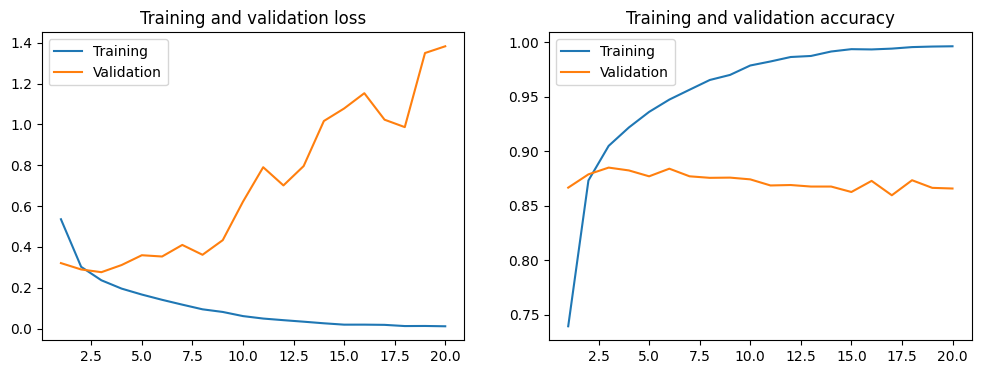

In [ ]:
plot_history(history) #

In [ ]:
# codes from Jérémie's ARTIFICIAL INTELLIGENCE (2023-24), Goldsmiths
# codes from Ch.11, DLWP

model = tf.keras.models.load_model(
    str(base_dir / "full_transformer_encoder.h5"),  # 确保文件名与代码3中保存的模型匹配
    custom_objects={"PositionalEmbedding": PositionalEmbedding, "TransformerEncoder": TransformerEncoder}  # 如果您在模型中使用了自定义层
)
print(f"Test acc: {model.evaluate(int_test_ds)[1]:.3f}")

782/782 [==============================] - 11s 14ms/step - loss: 0.2798 - accuracy: 0.8839
Test acc: 0.884


### 7-2-2.
#### According to the Occam's razor theory, one possible way to improve the model performance is to reduce it's complication. Because the number of parameters will be affected by the embedding dimension(vocab_size*embed_dim), therefore we could decrease the number of parameter by reducing the embedding dimension.We decide to change the embed_dim to 128. However, the best accuracy in validation set is no better, only 0.8778(epoch 6), than the embed_dim=256 model, and then appeared lost of overfitting. We should intorduce early stopping method.

In [ ]:
# codes from Jérémie's ARTIFICIAL INTELLIGENCE (2023-24), Goldsmiths
# codes from Ch.11, DLWP

vocab_size = 20000
sequence_length = 600
embed_dim = 128       # Change here, from 256 to 128
num_heads = 2
dense_dim = 32

inputs = tf.keras.Input(shape=(None,), dtype="int64")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(inputs) # 1. Positional embeddings
x = TransformerEncoder(embed_dim, dense_dim, num_heads)(x)              # 2. Transformer encoder
x = tf.keras.layers.GlobalMaxPooling1D()(x)                             #    (reduce full sequence to a vector...)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)
model = tf.keras.Model(inputs, outputs)
model.compile(
    optimizer="rmsprop",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        str(base_dir / "full_transformer_encoder.h5"),
        save_best_only=True
    )
]

history = model.fit(
    int_train_ds,
    validation_data=int_val_ds,
    epochs=20,
    callbacks=callbacks
)

Epoch 1/20
625/625 [==============================] - 40s 59ms/step - loss: 0.5140 - accuracy: 0.7473 - val_loss: 0.3261 - val_accuracy: 0.8588
Epoch 2/20
625/625 [==============================] - 23s 36ms/step - loss: 0.2835 - accuracy: 0.8830 - val_loss: 0.3344 - val_accuracy: 0.8686
Epoch 3/20
625/625 [==============================] - 19s 30ms/step - loss: 0.2211 - accuracy: 0.9122 - val_loss: 0.2908 - val_accuracy: 0.8740
Epoch 4/20
625/625 [==============================] - 16s 26ms/step - loss: 0.1844 - accuracy: 0.9292 - val_loss: 0.3274 - val_accuracy: 0.8794
Epoch 5/20
625/625 [==============================] - 15s 23ms/step - loss: 0.1598 - accuracy: 0.9412 - val_loss: 0.3182 - val_accuracy: 0.8766
Epoch 6/20
625/625 [==============================] - 15s 23ms/step - loss: 0.1340 - accuracy: 0.9499 - val_loss: 0.3933 - val_accuracy: 0.8778
Epoch 7/20
625/625 [==============================] - 14s 22ms/step - loss: 0.1100 - accuracy: 0.9601 - val_loss: 0.4582 - val_accuracy:

In [ ]:
# codes from Jérémie's ARTIFICIAL INTELLIGENCE (2023-24), Goldsmiths
# codes from Ch.11, DLWP

best_epoch = np.argmax(history.history['val_accuracy'])
best_val_accuracy = history.history['val_accuracy'][best_epoch]
print(f"Best Validation Accuracy: {best_val_accuracy:.4f} at Epoch {best_epoch+1}")

Best Validation Accuracy: 0.8776 at Epoch 6


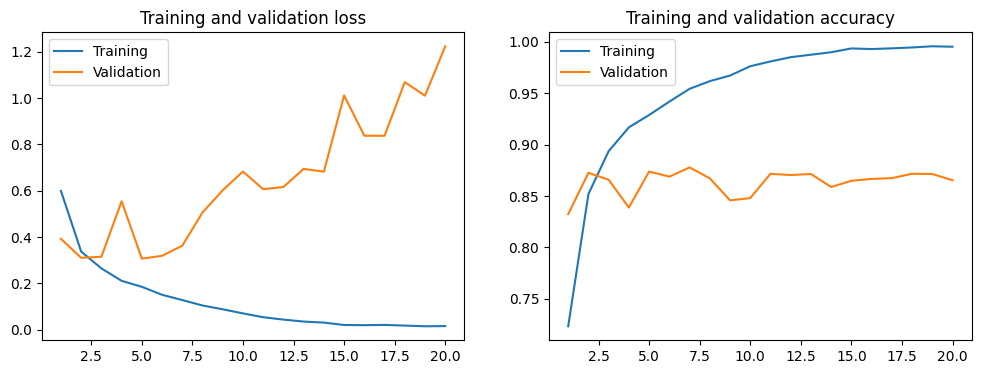

In [ ]:
# codes from Jérémie's ARTIFICIAL INTELLIGENCE (2023-24), Goldsmiths
# codes from Ch.11, DLWP

def plot_history(history):
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    acc = history.history["accuracy"]
    val_acc = history.history["val_accuracy"]
    epochs = range(1, len(loss) + 1)
    ax1.plot(epochs, loss, label="Training")
    ax1.plot(epochs, val_loss, label="Validation")
    ax1.set_title("Training and validation loss")
    ax1.legend()
    ax2.plot(epochs, acc, label="Training")
    ax2.plot(epochs, val_acc, label="Validation")
    ax2.set_title("Training and validation accuracy")
    ax2.legend()
    plt.show()
plot_history(history) #

### 7-2-3. Chang embed_size from 256 to 512.
#### However, even though higher embedding dimensions usually can provide more feature representation and capture more complex patterns(generalisation ability), but it accompaned with the risk of overfitting.
##### To responding our feedback on our coursework 1, "...we should activate silent mode when we using grid search...", so we tried "verbose=0" and see what will happened here. It works like training in silence and we can get which is the best epoch is, but the worse thing here is we can not observe the training process if we don't have the plots, even though we can infere that overfitting stated at epoch 8. We should really use silence training when perform grid search.



In [ ]:
# codes from Jérémie's ARTIFICIAL INTELLIGENCE (2023-24), Goldsmiths
# codes from Ch.11, DLWP

vocab_size = 20000
sequence_length = 600
embed_dim = 512         # Change here
num_heads = 2
dense_dim = 32

inputs = tf.keras.Input(shape=(None,), dtype="int64")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(inputs) # 1. Positional embeddings
x = TransformerEncoder(embed_dim, dense_dim, num_heads)(x)              # 2. Transformer encoder
x = tf.keras.layers.GlobalMaxPooling1D()(x)                             #    (reduce full sequence to a vector...)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)
model = tf.keras.Model(inputs, outputs)
model.compile(
    optimizer="rmsprop",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        str(base_dir / "full_transformer_encoder.h5"),
        save_best_only=True
    )
]

history = model.fit(
    int_train_ds,
    validation_data=int_val_ds,
    epochs=20,
    callbacks=callbacks,
    verbose=0  # silence mode
)

best_epoch = np.argmax(history.history['val_accuracy'])
best_val_accuracy = history.history['val_accuracy'][best_epoch]
print(f"Best Validation Accuracy: {best_val_accuracy:.4f} at Epoch {best_epoch+1}")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Best Validation Accuracy: 0.878 at Epoch 7


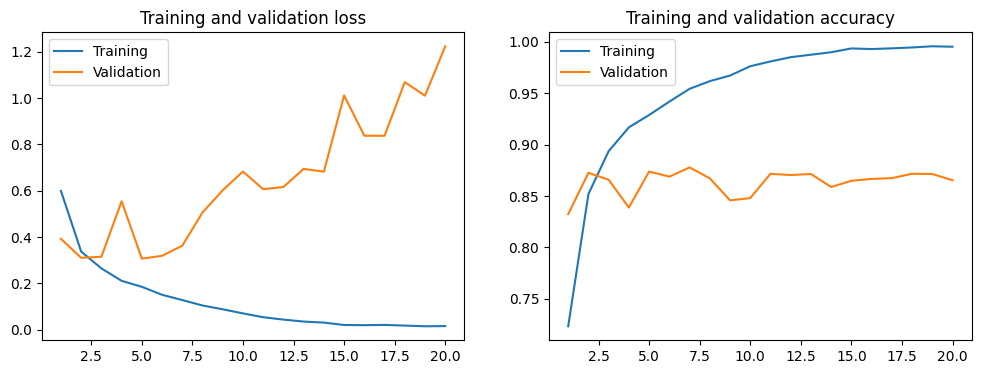

In [ ]:
# codes from Jérémie's ARTIFICIAL INTELLIGENCE (2023-24), Goldsmiths
# codes from Ch.11, DLWP

def plot_history(history):
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    acc = history.history["accuracy"]
    val_acc = history.history["val_accuracy"]
    epochs = range(1, len(loss) + 1)
    ax1.plot(epochs, loss, label="Training")
    ax1.plot(epochs, val_loss, label="Validation")
    ax1.set_title("Training and validation loss")
    ax1.legend()
    ax2.plot(epochs, acc, label="Training")
    ax2.plot(epochs, val_acc, label="Validation")
    ax2.set_title("Training and validation accuracy")
    ax2.legend()
    plt.show()
plot_history(history) #

### 7-2-4. Increase num_heads from 2 to 4.
#### Since transformer is famous of its mutihead attention mechnism, perhaps we can reach a better result by increase it head from 2 to 4. Unfortunately, the validation accuracy still doesn't improve and it is sitll overfitting in almost the begining starge.

In [ ]:
# codes from Jérémie's ARTIFICIAL INTELLIGENCE (2023-24), Goldsmiths
# codes from Ch.11, DLWP

vocab_size = 20000
sequence_length = 600
embed_dim = 256
num_heads = 4         # Chang here
dense_dim = 32

inputs = tf.keras.Input(shape=(None,), dtype="int64")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(inputs) # 1. Positional embeddings
x = TransformerEncoder(embed_dim, dense_dim, num_heads)(x)              # 2. Transformer encoder
x = tf.keras.layers.GlobalMaxPooling1D()(x)                             #    (reduce full sequence to a vector...)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)
model = tf.keras.Model(inputs, outputs)
model.compile(
    optimizer="rmsprop",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)
model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, None)]            0         
                                                                 
 positional_embedding_4 (Po  (None, None, 256)         5273600   
 sitionalEmbedding)                                              
                                                                 
 transformer_encoder_5 (Tra  (None, None, 256)         1069600   
 nsformerEncoder)                                                
                                                                 
 global_max_pooling1d_5 (Gl  (None, 256)               0         
 obalMaxPooling1D)                                               
                                                                 
 dropout_5 (Dropout)         (None, 256)               0         
                                                           

In [ ]:
# codes from Jérémie's ARTIFICIAL INTELLIGENCE (2023-24), Goldsmiths
# codes from Ch.11, DLWP

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        str(base_dir / "full_transformer_encoder.h5"),
        save_best_only=True
    )
]

history = model.fit(
    int_train_ds,
    validation_data=int_val_ds,
    epochs=20,
    callbacks=callbacks
)

Epoch 1/20
625/625 [==============================] - 47s 71ms/step - loss: 0.5415 - accuracy: 0.7398 - val_loss: 0.3183 - val_accuracy: 0.8612
Epoch 2/20
625/625 [==============================] - 35s 55ms/step - loss: 0.3059 - accuracy: 0.8717 - val_loss: 0.3545 - val_accuracy: 0.8610
Epoch 3/20
625/625 [==============================] - 30s 48ms/step - loss: 0.2396 - accuracy: 0.9038 - val_loss: 0.2953 - val_accuracy: 0.8762
Epoch 4/20
625/625 [==============================] - 29s 47ms/step - loss: 0.1957 - accuracy: 0.9219 - val_loss: 0.3490 - val_accuracy: 0.8646
Epoch 5/20
625/625 [==============================] - 28s 45ms/step - loss: 0.1651 - accuracy: 0.9374 - val_loss: 0.4942 - val_accuracy: 0.8562
Epoch 6/20
625/625 [==============================] - 27s 44ms/step - loss: 0.1428 - accuracy: 0.9464 - val_loss: 0.3755 - val_accuracy: 0.8776
Epoch 7/20
625/625 [==============================] - 27s 43ms/step - loss: 0.1221 - accuracy: 0.9541 - val_loss: 0.3676 - val_accuracy:

In [ ]:
# codes from Jérémie's ARTIFICIAL INTELLIGENCE (2023-24), Goldsmiths
# codes from Ch.11, DLWP

best_epoch = np.argmax(history.history['val_accuracy'])
best_val_accuracy = history.history['val_accuracy'][best_epoch]
print(f"Best Validation Accuracy: {best_val_accuracy:.4f} at Epoch {best_epoch+1}")

Best Validation Accuracy: 0.8776 at Epoch 6


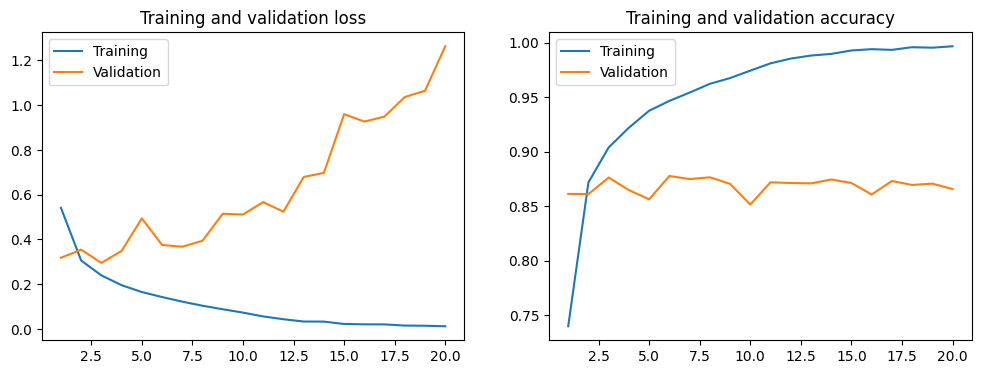

In [ ]:
# codes from Jérémie's ARTIFICIAL INTELLIGENCE (2023-24), Goldsmiths
# codes from Ch.11, DLWP

def plot_history(history):
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    acc = history.history["accuracy"]
    val_acc = history.history["val_accuracy"]
    epochs = range(1, len(loss) + 1)
    ax1.plot(epochs, loss, label="Training")
    ax1.plot(epochs, val_loss, label="Validation")
    ax1.set_title("Training and validation loss")
    ax1.legend()
    ax2.plot(epochs, acc, label="Training")
    ax2.plot(epochs, val_acc, label="Validation")
    ax2.set_title("Training and validation accuracy")
    ax2.legend()
    plt.show()
plot_history(history) #

### 7-2-5. Increase num_heads from 4 to 8.
#### Perhaps we need more attention? Let's increase number of head from 4 to 8. We also increase dense_dim to 1024 to increase parameters. Sadly, the validation accuracy remains almost same, 0.876. We also introduce early stopping in this model.

In [ ]:
# codes from Jérémie's ARTIFICIAL INTELLIGENCE (2023-24), Goldsmiths
# codes from Ch.11, DLWP

vocab_size = 20000
sequence_length = 600
embed_dim = 512
num_heads = 8
dense_dim = 1024

inputs = tf.keras.Input(shape=(None,), dtype="int64")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(inputs) # 1. Positional embeddings
x = TransformerEncoder(embed_dim, dense_dim, num_heads)(x)              # 2. Transformer encoder
x = tf.keras.layers.GlobalMaxPooling1D()(x)                             #    (reduce full sequence to a vector...)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)
model = tf.keras.Model(inputs, outputs)
model.compile(
    optimizer="rmsprop",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)
model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, None)]            0         
                                                                 
 positional_embedding_5 (Po  (None, None, 512)         10547200  
 sitionalEmbedding)                                              
                                                                 
 transformer_encoder_6 (Tra  (None, None, 512)         5253120   
 nsformerEncoder)                                                
                                                                 
 global_max_pooling1d_6 (Gl  (None, 512)               0         
 obalMaxPooling1D)                                               
                                                                 
 dropout_6 (Dropout)         (None, 512)               0         
                                                           

In [ ]:
# codes from ChatGPT 4, 23/12~31/12, 2023

# Define Early Stopping
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',        # monitor validation loss
    patience=3,                # stop if no improvement after 3 epochs
    restore_best_weights=True  # restore to the best weights
)

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        str(base_dir / "full_transformer_encoder.h5"),
        save_best_only=True
    ),
    early_stopping_callback  # Early Stopping
]

history = model.fit(
    int_train_ds,
    validation_data=int_val_ds,
    epochs=20,
    callbacks=callbacks
)

Epoch 1/20
625/625 [==============================] - 69s 107ms/step - loss: 0.6097 - accuracy: 0.7108 - val_loss: 0.4398 - val_accuracy: 0.7880
Epoch 2/20
625/625 [==============================] - 63s 101ms/step - loss: 0.3981 - accuracy: 0.8209 - val_loss: 0.3431 - val_accuracy: 0.8520
Epoch 3/20
625/625 [==============================] - 62s 99ms/step - loss: 0.3133 - accuracy: 0.8673 - val_loss: 0.3109 - val_accuracy: 0.8652
Epoch 4/20
625/625 [==============================] - 61s 98ms/step - loss: 0.2476 - accuracy: 0.9018 - val_loss: 0.3527 - val_accuracy: 0.8546
Epoch 5/20
625/625 [==============================] - 61s 98ms/step - loss: 0.1971 - accuracy: 0.9244 - val_loss: 0.3220 - val_accuracy: 0.8746
Epoch 6/20
625/625 [==============================] - 61s 97ms/step - loss: 0.1537 - accuracy: 0.9444 - val_loss: 0.3304 - val_accuracy: 0.8768


In [ ]:
# codes from ChatGPT 4, 23/12~31/12, 2023

best_epoch = np.argmax(history.history['val_accuracy'])
best_val_accuracy = history.history['val_accuracy'][best_epoch]
print(f"Best Validation Accuracy: {best_val_accuracy:.4f} at Epoch {best_epoch+1}")

Best Validation Accuracy: 0.8768 at Epoch 6


#### We don't change activation from Sigmoid to Relu/Tanh is because for claasification task, the expected output [1, 0] from sigmoid is the reasonable choice.


### 7-2-6. Change optimiser from RMSProp to Adam
#### ADAM combines the features of gradient descent momentum and RMSprop and it computes both a first-moment estimate of the gradient (i.e., the mean, similar to momentum) and a second-order moment estimate (i.e., the uncentered variance). Therefore, it takes into account not only the mean of the square of past gradients (like RMSprop), but also the mean of past gradients (i.e. momentum) to to update weights. Theoritically, the performance could be better than RMSprop to the same model. However, we can find the validation accuracy doesn't get better. Maybe we should consider adjust the hyper parameter that is Learning rate, β1 (decay rate of first-order moment estimate), β2 (decay rate of second-order moment estimate) of ADAM?

In [ ]:
# codes from Jérémie's ARTIFICIAL INTELLIGENCE (2023-24), Goldsmiths
# codes from Ch.11, DLWP

vocab_size = 20000
sequence_length = 600
embed_dim = 512
num_heads = 8
dense_dim = 1024

inputs = tf.keras.Input(shape=(None,), dtype="int64")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(inputs) # 1. Positional embeddings
x = TransformerEncoder(embed_dim, dense_dim, num_heads)(x)              # 2. Transformer encoder
x = tf.keras.layers.GlobalMaxPooling1D()(x)                             #    (reduce full sequence to a vector...)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)
model = tf.keras.Model(inputs, outputs)
model.compile(
    optimizer="adam",             # change from RMSprop to ADAM
    loss="binary_crossentropy",
    metrics=["accuracy"]
)
model.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, None)]            0         
                                                                 
 positional_embedding_7 (Po  (None, None, 512)         10547200  
 sitionalEmbedding)                                              
                                                                 
 transformer_encoder_8 (Tra  (None, None, 512)         9453568   
 nsformerEncoder)                                                
                                                                 
 global_max_pooling1d_8 (Gl  (None, 512)               0         
 obalMaxPooling1D)                                               
                                                                 
 dropout_8 (Dropout)         (None, 512)               0         
                                                           

In [ ]:
# codes from ChatGPT 4, 23/12~31/12, 2023

# Define Early Stopping
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',        # monitor validation loss
    patience=3,                # stop if no improvement after 3 epochs
    restore_best_weights=True  # restore to the best weights
)

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        str(base_dir / "full_transformer_encoder.h5"),
        save_best_only=True
    ),
    early_stopping_callback  # Early Stopping
]

history = model.fit(
    int_train_ds,
    validation_data=int_val_ds,
    epochs=20,
    callbacks=callbacks
)

Epoch 1/20
625/625 [==============================] - 112s 174ms/step - loss: 0.4826 - accuracy: 0.7743 - val_loss: 0.3203 - val_accuracy: 0.8710
Epoch 2/20
625/625 [==============================] - 107s 171ms/step - loss: 0.1912 - accuracy: 0.9265 - val_loss: 0.3860 - val_accuracy: 0.8740
Epoch 3/20
625/625 [==============================] - 107s 171ms/step - loss: 0.1127 - accuracy: 0.9596 - val_loss: 0.4206 - val_accuracy: 0.8764
Epoch 4/20
625/625 [==============================] - 107s 171ms/step - loss: 0.0910 - accuracy: 0.9679 - val_loss: 0.4442 - val_accuracy: 0.8698


### 7-2-7. The validation accuracy doesn't improve, so we decide to modify and encapsulate the Transformer model so that it is easier to change its architecture.

In [ ]:
# codes from ChatGPT 4, 23/12~31/12, 2023

# Define Transformer model
def build_transformer_model(vocab_size, sequence_length, embed_dim, num_heads, dense_dim, num_layers, batch_size):
    # input layer
    inputs = tf.keras.Input(shape=(sequence_length,), dtype="int64", batch_size=batch_size)  # Ensure the input shape contains the sequence length

    # embedding layer（could be replace as other embedding layer，such as GloVe）
    x = tf.keras.layers.Embedding(vocab_size, embed_dim)(inputs)

    # Transformer encoder layer
    for _ in range(num_layers):
        x = TransformerEncoder(embed_dim, dense_dim, num_heads)(x)

    # Global pooling and output layer
    x = tf.keras.layers.GlobalMaxPooling1D()(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)

    # build model
    model = tf.keras.Model(inputs, outputs)
    return model

### 7-2-8. Change batch size from 32 to 64. new_dense_dim = 512.
#### But neither do validation accuracy and overfitting has been improved.

In [ ]:
# codes from ChatGPT 4, 23/12~31/12, 2023

# new parameters
new_batch_size = 64
new_vocab_size = 20000
new_sequence_length = 600
new_embed_dim = 256
new_num_heads = 4
new_dense_dim = 512
new_num_layers = 2

#compile model with neew params
new_model = build_transformer_model(new_vocab_size, new_sequence_length, new_embed_dim, new_num_heads, new_dense_dim, new_num_layers, new_batch_size)
new_model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

# print model summary
new_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(64, 600)]               0         
                                                                 
 embedding_1 (Embedding)     (64, 600, 256)            5120000   
                                                                 
 transformer_encoder_2 (Tra  (64, 600, 256)            1315840   
 nsformerEncoder)                                                
                                                                 
 transformer_encoder_3 (Tra  (64, 600, 256)            1315840   
 nsformerEncoder)                                                
                                                                 
 global_max_pooling1d_1 (Gl  (64, 256)                 0         
 obalMaxPooling1D)                                               
                                                           

In [ ]:
# codes from ChatGPT 4, 23/12~31/12, 2023

# Early Stopping to recall to train new model
new_early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

new_callbacks = [
    tf.keras.callbacks.ModelCheckpoint("new_full_transformer_encoder.h5", save_best_only=True),
    new_early_stopping_callback
]

# trainin new model
new_history = new_model.fit(int_train_ds, validation_data=int_val_ds, epochs=20, callbacks=new_callbacks)

Epoch 1/20
625/625 [==============================] - ETA: 0s - loss: 0.5885 - accuracy: 0.6823

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


625/625 [==============================] - 77s 114ms/step - loss: 0.5885 - accuracy: 0.6823 - val_loss: 0.3886 - val_accuracy: 0.8326
Epoch 2/20
625/625 [==============================] - 61s 97ms/step - loss: 0.4006 - accuracy: 0.8189 - val_loss: 0.3670 - val_accuracy: 0.8368
Epoch 3/20
625/625 [==============================] - 57s 90ms/step - loss: 0.3233 - accuracy: 0.8637 - val_loss: 0.3515 - val_accuracy: 0.8474
Epoch 4/20
625/625 [==============================] - 53s 85ms/step - loss: 0.2300 - accuracy: 0.9091 - val_loss: 0.3909 - val_accuracy: 0.8624
Epoch 5/20
625/625 [==============================] - 52s 84ms/step - loss: 0.2704 - accuracy: 0.8943 - val_loss: 0.5551 - val_accuracy: 0.7372
Epoch 6/20
625/625 [==============================] - 52s 83ms/step - loss: 0.3746 - accuracy: 0.8459 - val_loss: 0.5290 - val_accuracy: 0.7380


### 7-2-9. Change batch size from 32 to 64. new_dense_dim = 256.
#### Both validation accuracy and overfitting has no improvement.

In [ ]:
# codes from ChatGPT 4, 23/12~31/12, 2023

# new parameters
new_batch_size = 64
new_vocab_size = 20000
new_sequence_length = 600
new_embed_dim = 256
new_num_heads = 4
new_dense_dim = 32
new_num_layers = 2

#compile model with neew params
new_model = build_transformer_model(new_vocab_size, new_sequence_length, new_embed_dim, new_num_heads, new_dense_dim, new_num_layers, new_batch_size)
new_model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

# print model summary
new_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(64, 600)]               0         
                                                                 
 embedding_2 (Embedding)     (64, 600, 256)            5120000   
                                                                 
 transformer_encoder_4 (Tra  (64, 600, 256)            1069600   
 nsformerEncoder)                                                
                                                                 
 transformer_encoder_5 (Tra  (64, 600, 256)            1069600   
 nsformerEncoder)                                                
                                                                 
 global_max_pooling1d_2 (Gl  (64, 256)                 0         
 obalMaxPooling1D)                                               
                                                           

In [ ]:
# codes from ChatGPT 4, 23/12~31/12, 2023

# Early Stopping
new_early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

new_callbacks = [
    tf.keras.callbacks.ModelCheckpoint("new_full_transformer_encoder.h5", save_best_only=True),
    new_early_stopping_callback
]

# train new model
new_history = new_model.fit(int_train_ds, validation_data=int_val_ds, epochs=20, callbacks=new_callbacks)

Epoch 1/20
625/625 [==============================] - 76s 114ms/step - loss: 0.5498 - accuracy: 0.7159 - val_loss: 0.3699 - val_accuracy: 0.8328
Epoch 2/20
625/625 [==============================] - 58s 93ms/step - loss: 0.3707 - accuracy: 0.8386 - val_loss: 0.3567 - val_accuracy: 0.8408
Epoch 3/20
625/625 [==============================] - 52s 84ms/step - loss: 0.2581 - accuracy: 0.8950 - val_loss: 0.4732 - val_accuracy: 0.8086
Epoch 4/20
625/625 [==============================] - 51s 82ms/step - loss: 0.2474 - accuracy: 0.9017 - val_loss: 0.3545 - val_accuracy: 0.8676
Epoch 5/20
625/625 [==============================] - 50s 80ms/step - loss: 0.1615 - accuracy: 0.9418 - val_loss: 0.3377 - val_accuracy: 0.8758
Epoch 6/20
625/625 [==============================] - 48s 77ms/step - loss: 0.1143 - accuracy: 0.9594 - val_loss: 0.4413 - val_accuracy: 0.8520
Epoch 7/20
625/625 [==============================] - 49s 78ms/step - loss: 0.1236 - accuracy: 0.9571 - val_loss: 0.4643 - val_accuracy

### 7-2-10. New model 3. Change new_num_heads = 4.
#### The validation accuracy 0.8820 is better than previous two models, but overfitting happened early.

In [ ]:
# codes from ChatGPT 4, 23/12~31/12, 2023

# new parameters
new_batch_size = 32
new_vocab_size = 20000
new_sequence_length = 600
new_embed_dim = 256
new_num_heads = 4
new_dense_dim = 32
new_num_layers = 2

#compile model with neew params
new_model = build_transformer_model(new_vocab_size, new_sequence_length, new_embed_dim, new_num_heads, new_dense_dim, new_num_layers, new_batch_size)
new_model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

# print model summary
new_model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(32, 600)]               0         
                                                                 
 embedding_3 (Embedding)     (32, 600, 256)            5120000   
                                                                 
 transformer_encoder_6 (Tra  (32, 600, 256)            1069600   
 nsformerEncoder)                                                
                                                                 
 transformer_encoder_7 (Tra  (32, 600, 256)            1069600   
 nsformerEncoder)                                                
                                                                 
 global_max_pooling1d_3 (Gl  (32, 256)                 0         
 obalMaxPooling1D)                                               
                                                           

In [ ]:
# codes from ChatGPT 4, 23/12~31/12, 2023

# Early Stopping
new_early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

new_callbacks = [
    tf.keras.callbacks.ModelCheckpoint("new_full_transformer_encoder.h5", save_best_only=True),
    new_early_stopping_callback
]

# train new model
new_history = new_model.fit(int_train_ds, validation_data=int_val_ds, epochs=20, callbacks=new_callbacks)

Epoch 1/20
625/625 [==============================] - 77s 116ms/step - loss: 0.5736 - accuracy: 0.6972 - val_loss: 0.4369 - val_accuracy: 0.7884
Epoch 2/20
625/625 [==============================] - 59s 94ms/step - loss: 0.3740 - accuracy: 0.8389 - val_loss: 0.3217 - val_accuracy: 0.8658
Epoch 3/20
625/625 [==============================] - 52s 82ms/step - loss: 0.2497 - accuracy: 0.9018 - val_loss: 0.3262 - val_accuracy: 0.8820
Epoch 4/20
625/625 [==============================] - 50s 80ms/step - loss: 0.1842 - accuracy: 0.9306 - val_loss: 0.4354 - val_accuracy: 0.8470
Epoch 5/20
625/625 [==============================] - 50s 79ms/step - loss: 0.1863 - accuracy: 0.9316 - val_loss: 0.3890 - val_accuracy: 0.8466


### 7-2-11. New model 4. Change new_num_heads from 4 to 2.
#### Both validation accuracy and overfitting improve less.

In [ ]:
# codes from ChatGPT 4, 23/12~31/12, 2023

# new parameters
new_batch_size = 32
new_vocab_size = 20000
new_sequence_length = 600
new_embed_dim = 256
new_num_heads = 2
new_dense_dim = 32
new_num_layers = 2

#compile model with neew params
new_model = build_transformer_model(new_vocab_size, new_sequence_length, new_embed_dim, new_num_heads, new_dense_dim, new_num_layers, new_batch_size)
new_model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

# print model summary
new_model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(32, 600)]               0         
                                                                 
 embedding_5 (Embedding)     (32, 600, 256)            5120000   
                                                                 
 transformer_encoder_10 (Tr  (32, 600, 256)            543776    
 ansformerEncoder)                                               
                                                                 
 transformer_encoder_11 (Tr  (32, 600, 256)            543776    
 ansformerEncoder)                                               
                                                                 
 global_max_pooling1d_5 (Gl  (32, 256)                 0         
 obalMaxPooling1D)                                               
                                                           

In [ ]:
# codes from ChatGPT 4, 23/12~31/12, 2023

# Early Stopping
new_early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

new_callbacks = [
    tf.keras.callbacks.ModelCheckpoint("new_full_transformer_encoder.h5", save_best_only=True),
    new_early_stopping_callback
]

# train new model
new_history = new_model.fit(int_train_ds, validation_data=int_val_ds, epochs=20, callbacks=new_callbacks)

Epoch 1/20
625/625 [==============================] - 66s 97ms/step - loss: 0.5081 - accuracy: 0.7521 - val_loss: 0.3465 - val_accuracy: 0.8472
Epoch 2/20
625/625 [==============================] - 44s 71ms/step - loss: 0.3388 - accuracy: 0.8558 - val_loss: 0.3444 - val_accuracy: 0.8496
Epoch 3/20
625/625 [==============================] - 36s 58ms/step - loss: 0.2495 - accuracy: 0.8979 - val_loss: 0.3054 - val_accuracy: 0.8708
Epoch 4/20
625/625 [==============================] - 33s 52ms/step - loss: 0.1944 - accuracy: 0.9244 - val_loss: 0.3571 - val_accuracy: 0.8598
Epoch 5/20
625/625 [==============================] - 32s 51ms/step - loss: 0.2555 - accuracy: 0.8986 - val_loss: 0.3553 - val_accuracy: 0.8724
Epoch 6/20
625/625 [==============================] - 31s 49ms/step - loss: 0.1559 - accuracy: 0.9427 - val_loss: 0.4013 - val_accuracy: 0.8660


### 7-2-12. New model 5. Change new_num_heads from 4, and compile the model with a custom optimizer (custom learning rate=0.0005)
#### Both validation accuracy and overfitting improve less.

In [ ]:
# codes from ChatGPT 4, 23/12~31/12, 2023

# new parameters
new_batch_size = 32
new_vocab_size = 20000
new_sequence_length = 600
new_embed_dim = 256
new_num_heads = 4
new_dense_dim = 32
new_num_layers = 2

# define custom learning rate
learning_rate = 0.0005
# Create an Adam optimizer instance with a custom learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

# Build a model with new parameters
new_model = build_transformer_model(new_vocab_size, new_sequence_length, new_embed_dim, new_num_heads, new_dense_dim, new_num_layers, new_batch_size)

# Compile the model with a custom optimizer
new_model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])

# model summary
new_model.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(32, 600)]               0         
                                                                 
 embedding_8 (Embedding)     (32, 600, 256)            5120000   
                                                                 
 transformer_encoder_17 (Tr  (32, 600, 256)            1069600   
 ansformerEncoder)                                               
                                                                 
 transformer_encoder_18 (Tr  (32, 600, 256)            1069600   
 ansformerEncoder)                                               
                                                                 
 global_max_pooling1d_8 (Gl  (32, 256)                 0         
 obalMaxPooling1D)                                               
                                                           

In [ ]:
# codes from ChatGPT 4, 23/12~31/12, 2023

# Early Stopping
new_early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

new_callbacks = [
    tf.keras.callbacks.ModelCheckpoint("new_full_transformer_encoder.h5", save_best_only=True),
    new_early_stopping_callback
]

# train new model
new_history = new_model.fit(int_train_ds, validation_data=int_val_ds, epochs=20, callbacks=new_callbacks)

Epoch 1/20
625/625 [==============================] - 77s 115ms/step - loss: 0.5294 - accuracy: 0.7331 - val_loss: 0.3671 - val_accuracy: 0.8482
Epoch 2/20
625/625 [==============================] - 59s 94ms/step - loss: 0.3262 - accuracy: 0.8605 - val_loss: 0.3271 - val_accuracy: 0.8644
Epoch 3/20
625/625 [==============================] - 53s 84ms/step - loss: 0.2526 - accuracy: 0.8967 - val_loss: 0.3389 - val_accuracy: 0.8658
Epoch 4/20
625/625 [==============================] - 50s 79ms/step - loss: 0.1829 - accuracy: 0.9287 - val_loss: 0.3923 - val_accuracy: 0.8382
Epoch 5/20
625/625 [==============================] - 49s 78ms/step - loss: 0.1228 - accuracy: 0.9541 - val_loss: 0.3484 - val_accuracy: 0.8732


### 7-2-13. New model 6. Change new_num_heads from 4, and compile the model with a custom optimizer (custom learning rate=0.0003)
#### Both validation accuracy and overfitting improve less.

In [ ]:
# codes from ChatGPT 4, 23/12~31/12, 2023

# new parameters
new_batch_size = 32
new_vocab_size = 20000
new_sequence_length = 600
new_embed_dim = 256
new_num_heads = 4
new_dense_dim = 32
new_num_layers = 2

# define custom learning rate
learning_rate = 0.0003
# Create an Adam optimizer instance with a custom learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

# Build a model with new parameters
new_model = build_transformer_model(new_vocab_size, new_sequence_length, new_embed_dim, new_num_heads, new_dense_dim, new_num_layers, new_batch_size)

# Compile the model with a custom optimizer
new_model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])

# model summary
new_model.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(32, 600)]               0         
                                                                 
 embedding_9 (Embedding)     (32, 600, 256)            5120000   
                                                                 
 transformer_encoder_19 (Tr  (32, 600, 256)            1069600   
 ansformerEncoder)                                               
                                                                 
 transformer_encoder_20 (Tr  (32, 600, 256)            1069600   
 ansformerEncoder)                                               
                                                                 
 global_max_pooling1d_9 (Gl  (32, 256)                 0         
 obalMaxPooling1D)                                               
                                                           

In [ ]:
# codes from ChatGPT 4, 23/12~31/12, 2023

# Early Stopping
new_early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

new_callbacks = [
    tf.keras.callbacks.ModelCheckpoint("new_full_transformer_encoder.h5", save_best_only=True),
    new_early_stopping_callback
]

# train new model
new_history = new_model.fit(int_train_ds, validation_data=int_val_ds, epochs=20, callbacks=new_callbacks)

Epoch 1/20
625/625 [==============================] - 77s 116ms/step - loss: 0.5350 - accuracy: 0.7287 - val_loss: 0.3373 - val_accuracy: 0.8578
Epoch 2/20
625/625 [==============================] - 58s 92ms/step - loss: 0.3230 - accuracy: 0.8606 - val_loss: 0.3143 - val_accuracy: 0.8652
Epoch 3/20
625/625 [==============================] - 54s 86ms/step - loss: 0.2488 - accuracy: 0.9002 - val_loss: 0.3135 - val_accuracy: 0.8712
Epoch 4/20
625/625 [==============================] - 50s 80ms/step - loss: 0.1875 - accuracy: 0.9248 - val_loss: 0.3489 - val_accuracy: 0.8696
Epoch 5/20
625/625 [==============================] - 50s 80ms/step - loss: 0.1320 - accuracy: 0.9493 - val_loss: 0.3550 - val_accuracy: 0.8666
Epoch 6/20
625/625 [==============================] - 49s 78ms/step - loss: 0.0889 - accuracy: 0.9657 - val_loss: 0.4315 - val_accuracy: 0.8694


### 7-2-13. Conclusion for testing on Transformer model:
#### After trying different hyperparameters, we can find that the convergence speed is too fast so the overfitting always happened early. There are some possible way we may use for a better consequence in the future and adopt them early rather than try and error for too many times (but these are still meaningful runs):

##### 1. Data augmentation:
##### Enhance the training data, such as word replacement, sentence rearrangement, etc. to increase the diversity of the data.

##### 2. Regularization:
##### Applying regularization techniques, such as L1 or L2 regularization, can help reduce model complexity and overfitting.

##### 3. Learning rate adjustment:
##### Adjust the learning rate or use a learning rate decay strategy. Sometimes, a smaller learning rate can prevent the model from converging too quickly and improve generalization ability.

##### 4. Use learning rate warm-up:
##### Gradually increase the learning rate at the beginning of training, which is especially effective when training Transformer models.

##### 5. More complex optimizers:
##### Use a more sophisticated optimizer like AdamW, which combines the advantages of weight decay and the Adam optimizer.

# 7-3. Bidirectional LSTM - DLWP 11.1
#### The mean words number of IMDB movie review is around 234. According to DLWP "...RNN dominated NLP during 2015 to 2017, bidriectional LSTM is the top...", so we want to check the performance of bidirectional LSTM could perform better than transformer in classification task.
#### The validation accuraacy reach to 0.887, which is almost as same as Transformer, but BiLSTM requires less compute resorce because it contains less paramerters. Overall, this is a nice try.

In [ ]:
# codes from ChatGPT 4, 23/12~31/12, 2023

def build_and_compile_lstm_model(vocab_size, sequence_length, lstm_units, num_layers, dropout_rate):
    inputs = tf.keras.Input(shape=(sequence_length,), dtype="int64")
    x = tf.keras.layers.Embedding(vocab_size, output_dim=128)(inputs)

    # Stack bidirectional LSTM layers
    for _ in range(num_layers):
        x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_units, return_sequences=True))(x)
        x = tf.keras.layers.Dropout(dropout_rate)(x)

    # Add a global average pooling layer to reduce dimensions
    x = tf.keras.layers.GlobalAveragePooling1D()(x)

    # Output layer
    outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)

    # Build model
    model = tf.keras.Model(inputs, outputs)

    # Compile model
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    return model

In [ ]:
# codes from ChatGPT 4, 23/12~31/12, 2023

# Set model parameters
lstm_units = 128
num_layers = 2
dropout_rate = 0.5

# Build and compile the LSTM model
lstm_model = build_and_compile_lstm_model(max_tokens, max_length, lstm_units, num_layers, dropout_rate)

# Define EarlyStopping callback
new_early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=3,
    verbose=1,                 # print early stoping message
    mode='min',                # we monitor validation loss here，so the mode is min
    restore_best_weights=True
)

# model summary
lstm_model.summary()

# training LSTM model
lstm_history = lstm_model.fit(
    int_train_ds,
    validation_data=int_val_ds,
    epochs=20,
    callbacks=[new_early_stopping_callback]
)

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 600)]             0         
                                                                 
 embedding_5 (Embedding)     (None, 600, 128)          2560000   
                                                                 
 bidirectional_10 (Bidirect  (None, 600, 256)          263168    
 ional)                                                          
                                                                 
 dropout_10 (Dropout)        (None, 600, 256)          0         
                                                                 
 bidirectional_11 (Bidirect  (None, 600, 256)          394240    
 ional)                                                          
                                                                 
 dropout_11 (Dropout)        (None, 600, 256)          0   

# 7-4. GloVe word embedding vectors
#### The interesting things here is that it demonstrate overfitting but still reach the best validation accuracy and minimum validation loss at epoch 10. A possible explanation could be that the GloVe contains some information that doesn't exsist in the training dataset.

#### Download GloVe by Standford.

In [ ]:
# codes from Ch.11, DLWP

!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

--2024-01-13 23:29:01--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2024-01-13 23:29:01--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2024-01-13 23:29:02--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip.1’

gl

### Parsing the GloVe word embedding vector archive

In [ ]:
# codes from Ch.11, DLWP

path_to_glove_file = "glove.6B.100d.txt"

embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print(f"Found {len(embeddings_index)} word vectors.")

Found 400000 word vectors.


### Prepare GloVe word embedding matrix

In [ ]:
# codes from Ch.11, DLWP

embedding_dim = 100

vocabulary = text_vectorization.get_vocabulary()
word_index = dict(zip(vocabulary, range(len(vocabulary))))

embedding_matrix = np.zeros((max_tokens, embedding_dim))
for word, i in word_index.items():
    if i < max_tokens:
        embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [ ]:
# codes from Ch.11, DLWP

embedding_layer = layers.Embedding(
    max_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False,
    mask_zero=True,
)

### Using pre-trained Embedding layer model

In [ ]:
# codes from Ch.11, DLWP

inputs = keras.Input(shape=(None,), dtype="int64")
embedded = embedding_layer(inputs)
x = layers.Bidirectional(layers.LSTM(32))(embedded)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop",
       loss="binary_crossentropy",
       metrics=["accuracy"])
model.summary()

callbacks = [
    keras.callbacks.ModelCheckpoint("glove_embeddings_sequence_model.keras",
                    save_best_only=True)
]

model.fit(int_train_ds, validation_data=int_val_ds, epochs=10, callbacks=callbacks)
model = keras.models.load_model("glove_embeddings_sequence_model.keras")
print(f"Test acc: {model.evaluate(int_test_ds)[1]:.3f}")

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_7 (Embedding)     (None, None, 100)         2000000   
                                                                 
 bidirectional_13 (Bidirect  (None, 64)                34048     
 ional)                                                          
                                                                 
 dropout_13 (Dropout)        (None, 64)                0         
                                                                 
 dense_7 (Dense)             (None, 1)                 65        
                                                                 
Total params: 2034113 (7.76 MB)
Trainable params: 34113 (133.25 KB)
Non-trainable params: 2000000 (7.63 MB)
_________________

# **Key Differences Among the Three Methods, namely Bag-of-Words: N-gram (N=2), Binary Bigram Model, and TF-IDF Bigram Model**

| **Method**             | **Feature Values**   | **Considers Term Frequency** | **Considers Global Corpus** | **Best Use Cases**             |
|-------------------------|----------------------|------------------------------|-----------------------------|---------------------------------|
| **Bag-of-Words: N-gram** | Word pair frequency | Yes                          | No                          | Basic text classification      |
| **Binary Bigram Model** | Binary (0 or 1)     | No                           | No                          | Short text classification      |
| **TF-IDF Bigram Model** | TF-IDF weights      | Yes                          | Yes                         | Importance-based text analysis |

---

## **Conclusion**
Each method serves a distinct purpose depending on the dataset and task requirements:
- **Bag-of-Words: N-gram**: Best for capturing simple word relationships in text.
- **Binary Bigram Model**: Useful for quick classification where high-frequency terms might dominate.
- **TF-IDF Bigram Model**: Effective for highlighting rare but significant terms while suppressing common ones.

# 7-5. Bag-of-words: N-gram(N=2)
#### The training process looks smoothly even the overfitting happened slightly. The best validation accuracy reach to 0.89, which is a good performance.

### Pre-process the dataset with TextVectorization layer
#### Suppose the vocabulary contains only three words ["apple", "banana", "orange"], then the text "apple and banana" will be converted into a vector [1, 1, 0], because "apple" and "banana" appears in the text, but "orange" does not. This approach is suitable for certain types of text analysis tasks, especially when the occurrence of specific words in the text is more important than their order. However, the the classification performance is good.

In [ ]:
# codes from Ch.11, DLWP

text_vectorization = TextVectorization(
    max_tokens=20000,
    output_mode="multi_hot",
)
text_only_train_ds = train_ds.map(lambda x, y: x)
text_vectorization.adapt(text_only_train_ds)

binary_1gram_train_ds = train_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
binary_1gram_val_ds = val_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
binary_1gram_test_ds = test_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)

### Check the output of binary unigram data set

In [ ]:
# codes from Ch.11, DLWP

for inputs, targets in binary_1gram_train_ds:
    print("inputs.shape:", inputs.shape)
    print("inputs.dtype:", inputs.dtype)
    print("targets.shape:", targets.shape)
    print("targets.dtype:", targets.dtype)

    print("inputs[0]:", inputs[0])
    print("targets[0]:", targets[0])
    break

inputs.shape: (32, 20000)
inputs.dtype: <dtype: 'float32'>
targets.shape: (32,)
targets.dtype: <dtype: 'int32'>
inputs[0]: tf.Tensor([1. 1. 1. ... 0. 0. 0.], shape=(20000,), dtype=float32)
targets[0]: tf.Tensor(1, shape=(), dtype=int32)


### modeling function

In [ ]:
# codes from Ch.11, DLWP

def get_model(max_tokens=20000, hidden_dim=16):
    inputs = keras.Input(shape=(max_tokens,))
    x = layers.Dense(hidden_dim, activation="relu")(inputs)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    model = keras.Model(inputs, outputs)
    model.compile(optimizer="rmsprop",
                  loss="binary_crossentropy",
                  metrics=["accuracy"])
    return model

### Train and test the binary unigram model

In [ ]:
# codes from Ch.11, DLWP

model = get_model()
model.summary()
callbacks = [
    keras.callbacks.ModelCheckpoint("binary_1gram.keras",
                                    save_best_only=True)
]
model.fit(binary_1gram_train_ds.cache(),
          validation_data=binary_1gram_val_ds.cache(),
          epochs=10,
          callbacks=callbacks)
model = keras.models.load_model("binary_1gram.keras")
print(f"Test acc: {model.evaluate(binary_1gram_test_ds)[1]:.4f}")

Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 20000)]           0         
                                                                 
 dense_14 (Dense)            (None, 16)                320016    
                                                                 
 dropout_17 (Dropout)        (None, 16)                0         
                                                                 
 dense_15 (Dense)            (None, 1)                 17        
                                                                 
Total params: 320033 (1.22 MB)
Trainable params: 320033 (1.22 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10
625/625 [==============================] - 31s 49ms/step - loss: 0.4109 - accuracy: 0.8283 - val_loss: 0.2950 - val_accuracy: 0.8778
Epoch 2/10

# 7-6. Bigram
#### Appear the best performance of IMDB movie review classification task, which test accuracy is 0.896, and almost 0.90 at the first epoch, but overfitting started from almost first two epoch.

#### Create a TextVectorization layer that can pass back the bigram

In [ ]:
# codes from Ch.11, DLWP

text_vectorization = TextVectorization(
    ngrams=2,                 # "The quick brown fox" will be process as  "The quick"、"quick brown" 和 "brown fox".
    max_tokens=20000,
    output_mode="multi_hot",
)

### Train and test a binary bigram model

In [ ]:
# codes from Ch.11, DLWP

text_vectorization.adapt(text_only_train_ds)
binary_2gram_train_ds = train_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
binary_2gram_val_ds = val_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
binary_2gram_test_ds = test_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)

model = get_model()
model.summary()
callbacks = [
    keras.callbacks.ModelCheckpoint("binary_2gram.keras",
                                    save_best_only=True)
]
model.fit(binary_2gram_train_ds.cache(),
          validation_data=binary_2gram_val_ds.cache(),
          epochs=10,
          callbacks=callbacks)
model = keras.models.load_model("binary_2gram.keras")
print(f"Test acc: {model.evaluate(binary_2gram_test_ds)[1]:.3f}")

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 20000)]           0         
                                                                 
 dense_10 (Dense)            (None, 16)                320016    
                                                                 
 dropout_15 (Dropout)        (None, 16)                0         
                                                                 
 dense_11 (Dense)            (None, 1)                 17        
                                                                 
Total params: 320033 (1.22 MB)
Trainable params: 320033 (1.22 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10
625/625 [==============================] - 32s 50ms/step - loss: 0.3878 - accuracy: 0.8417 - val_loss: 0.2718 - val_accuracy: 0.8944
Epoch 2/10


# 7-7. TF-IDF bigram model
#### The test performance also good, which is 0.893, but the overfitting situation is relatively dramastically.

#### Configure the TextVectorization layer to return the number of occurrences of bigram

In [ ]:
# codes from Ch.11, DLWP

text_vectorization = TextVectorization(
    ngrams=2,
    max_tokens=20000,
    output_mode="count"
)

#### Use TextVectorization to return the TF-IDF weighted output result

In [ ]:
# codes from Ch.11, DLWP

text_vectorization = TextVectorization(
    ngrams=2,
    max_tokens=20000,
    output_mode="tf_idf",
)

#### Train and test the TF-IDF bigram model

In [ ]:
# codes from Ch.11, DLWP

text_vectorization.adapt(text_only_train_ds)

tfidf_2gram_train_ds = train_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
tfidf_2gram_val_ds = val_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
tfidf_2gram_test_ds = test_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)

model = get_model()
model.summary()
callbacks = [
    keras.callbacks.ModelCheckpoint("tfidf_2gram.keras",
                     save_best_only=True)
]
model.fit(tfidf_2gram_train_ds.cache(),
      validation_data=tfidf_2gram_val_ds.cache(),
      epochs=10,
      callbacks=callbacks)
model = keras.models.load_model("tfidf_2gram.keras")
print(f"Test acc: {model.evaluate(tfidf_2gram_test_ds)[1]:.3f}")

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 20000)]           0         
                                                                 
 dense_12 (Dense)            (None, 16)                320016    
                                                                 
 dropout_16 (Dropout)        (None, 16)                0         
                                                                 
 dense_13 (Dense)            (None, 1)                 17        
                                                                 
Total params: 320033 (1.22 MB)
Trainable params: 320033 (1.22 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10
625/625 [==============================] - 32s 50ms/step - loss: 0.4636 - accuracy: 0.7868 - val_loss: 0.2892 - val_accuracy: 0.8910
Epoch 2/10

# 8. Created a new model for inference (inference_model) that accepts raw text as input and outputs the model's predictions.

In [ ]:
# codes from Ch.11, DLWP

inputs = keras.Input(shape=(1,), dtype="string")
processed_inputs = text_vectorization(inputs)
outputs = model(processed_inputs)
inference_model = keras.Model(inputs, outputs)    # inference model

In [ ]:
# codes from Ch.11, DLWP

raw_text_data = tf.convert_to_tensor([                        # prediction sample
    ["That was an excellent movie, I loved it."],
])
predictions = inference_model(raw_text_data)                  # prediction
print(f"{float(predictions[0] * 100):.2f} percent positive")  # prediction output

87.16 percent positive


# 9. Attention is all we need?
#### First thing first, deep learning is really a game of resources. The resource is not only VGA but also is time. At first, I thought free T4 GPU would be enough for our model training. But at the first time I ran a code in Chaoter 9, DLWP, I realised that the game is changed, we may need a better approach because it is time consuming. When I ran first transformer model, I'm 1000% for sure this is the game of resource, it is impossible to ran model on just free T4 GPU because the runing-out-of-time problem is way sevre than the time consuming issue. Second, even though transformer provide a very different and useful apporach to machine leaning, but we have to consider the resource we have because nothing in this field is free if we want to achieve diffrent purpose. Furthermore, we could say that techniques and applications in this field is envolve in a daily pace, we could learn/heard something new eryday we wake up.

# 10. References
#### Chollet F., 2021, Ch.1-6, Deep Learning with Python, Second Edition, Manning
#### Wenger J., Week6-10, 2023-2024, Lecture and Lab materials, IS53024B/S/IS71039B/A: ARTIFICIAL INTELLIGENCE (2023-24), Goldsmiths, UoL
#### ChatGPT 4, 23/12~31/12, 2023
#### Google Translate, 23/12/2023~ 15/1/2023
#### LAKSHMIPATHI N,Sentiment Analysis of IMDB Movie Reviews, Avaliable: https://www.kaggle.com/code/lakshmi25npathi/sentiment-analysis-of-imdb-movie-reviews?kernelSessionId=40627787
#### DERRELL, IMDB sentiment analysis - EDA, ML, LSTM, BERT, Avaliable: https://www.kaggle.com/code/derrelldsouza/imdb-sentiment-analysis-eda-ml-lstm-bert?kernelSessionId=68871348
#### ALEX CHERNIUK, IMDB review Word2Vec & BiLSTM - 99% acc, Avaliable: https://www.kaggle.com/code/alexcherniuk/imdb-review-word2vec-bilstm-99-acc?kernelSessionId=13518574
#### DSANGEETHA, Analysis on IMDB movies, Avaliable: https://www.kaggle.com/code/devisangeetha/analysis-on-imdb-movies?kernelSessionId=1886812
#### HARSHAL GADHE, IMDB sentiment Classifier ~ 97% accuracy model, Avaliable: https://www.kaggle.com/code/harshalgadhe/imdb-sentiment-classifier-97-accuracy-model
#### Sanghvirajit, A Complete Guide to Adam and RMSprop Optimizer, Avaliable: https://medium.com/analytics-vidhya/a-complete-guide-to-adam-and-rmsprop-optimizer-75f4502d83be
#### Lili Jiang, A Visual Explanation of Gradient Descent Methods (Momentum, AdaGrad, RMSProp, Adam), Avaliable: https://towardsdatascience.com/a-visual-explanation-of-gradient-descent-methods-momentum-adagrad-rmsprop-adam-f898b102325c
#### Artem Oppermann, Optimization in deep learning: AdaGrad,RMSProp, Adam, Avaliable: https://artemoppermann.com/optimization-in-deep-learning-adagrad-rmsprop-adam/